In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

from sklearn.model_selection import train_test_split, cross_val_score

# from sklearn.metrics import r2_score, make_scorer, mean_squared_error

from sympy import Symbol, parse_expr, simplify, lambdify
# from copy import deepcopy


from pyoperon.sklearn import SymbolicRegressor
# from pyoperon import R2, MSE, InfixFormatter, FitLeastSquares, Interpreter


In [3]:
# Read Nikuradse dataset
df = pd.read_csv('nikuradse_2.tsv.gz', sep='\t')
X = np.array(df.iloc[:,:-1])
y = np.array(df.iloc[:, -1])

print(f'X shape: {np.shape(X)}')
print(f'X shape: {np.shape(X)}')


X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.66)
# X_train, y_train = X[0:231, :], y[0:231]
# X_test, y_test = X[231:361, :], y[231:361]

sErr = 0.05  # estimated value for sigma error (used for model selection)

print(f'X_train shape: {np.shape(X_train)}')
print(f'X_test shape: {np.shape(X_test)}')


X shape: (362, 1)
X shape: (362, 1)
X_train shape: (238, 1)
X_test shape: (124, 1)


In [ ]:

reg = SymbolicRegressor(
        allowed_symbols= "add,sub,mul,div,constant,variable", # pow, abs, sqrt, cbrt, tanh, sin, cos, aq, ...
        population_size= 1000,    # 100 ... 10000
        pool_size= 1000,          # same as population_size 
        generations= 50,          # 25 .. 200
        female_selector= "tournament",
        male_selector= "tournament",
        tournament_size= 3,       # popsize->tournament size:  100 -> 2, 500 -> 3, 1000 -> 5, 10000 -> 7 
        optimizer_iterations= 30, # 10 - 30 iterations
        optimizer='lm',   
        epsilon= 1e-05,
        max_evaluations= 1000000, # should be at least population_size * generations * optimizer_iterations 
        max_length= 50,           # limit for the number of nodes: 10, 15, 25, 30, 50, 100 (larger is not typical)
        model_selection_criterion= "minimum_description_length", # best model is selected from the Pareto front using MDL
        mutation_probability= 0.15, # 5% .. 25%
        objectives= [ 'r2', 'length' ],
        random_state= None,
        uncertainty= [sErr],      # sigma error used for Gaussian likelihood in MDL model selection
        n_threads=0               # number of threads to use (0=auto)
        )

reg.fit(X_train, y_train)



SymbolicRegressor(generations=50, mutation_probability=0.15, n_threads=0,
                  objectives=['r2', 'length'], optimizer_iterations=30,
                  pool_size=1000, random_state=2456344386825852262,
                  time_limit=9223372036854775807, tournament_size=3,
                  uncertainty=[0.05])

In [5]:

res = [(s['objective_values'], s['tree'], s['minimum_description_length']) for s in reg.pareto_front_]
for obj, expr, mdl in res:
    print(obj, mdl, reg.get_model_string(expr, 16))


[-0.005761976353824139, 5.0] 2652.662353515625 (1.7589370012283325 + (0.0275468006730080 * (0.9029852151870728 * X1)))
[-0.006640007719397545, 7.0] 2654.62353515625 (1.8248152732849121 + ((-0.0600443966686726) * ((0.7948102951049805 * X1) * (0.1641958802938461 * X1))))
[-0.44458672404289246, 9.0] 1283.258544921875 (0.3853171765804291 + (13.0895185470581055 * (((-1.4967702627182007) * X1) / ((-1.2319365739822388) + ((-12.6469144821166992) * X1)))))
[-0.5737404823303223, 11.0] 885.80615234375 (0.4760088622570038 + (0.3173764944076538 * (((18.6263980865478516 * X1) / (0.8750711679458618 + (3.1415927410125732 * X1))) - (0.3846007585525513 * X1))))
[-0.8136812448501587, 13.0] 129.7072296142578 (0.3089799582958221 + (0.3104923963546753 * (((2.5069456100463867 * X1) / (0.2149260789155960 + (0.2403773218393326 * X1))) / ((0.4619175195693970 * X1) + 0.5551515221595764))))
[-0.9618233442306519, 15.0] -325.997314453125 (0.8327185511589050 + (0.5236670970916748 * ((4.0512042045593262 / ((4.2677178

RMSE (training): 0.0404
RMSE (test): 0.0393


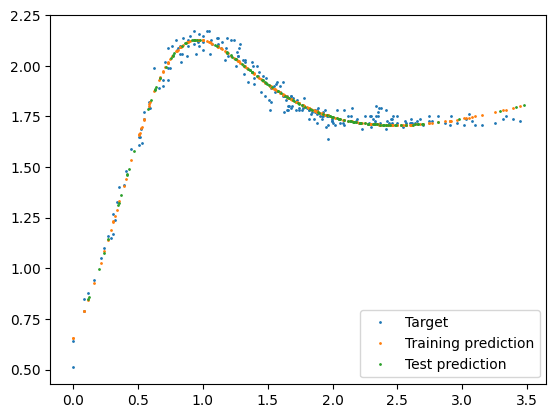

In [6]:
y_train_pred = reg.predict(X_train)
y_test_pred = reg.predict(X_test)

r_train = (y_train - y_train_pred)
r_test = (y_test - y_test_pred)
MSE_train = 1/len(r_train) * r_train.T @ r_train
MSE_test = 1/len(r_test) * r_test.T @ r_test
print(f'RMSE (training): {math.sqrt(MSE_train):0.3}')
print(f'RMSE (test): {math.sqrt(MSE_test):0.3}')

plt.plot(X_train[:,0], y_train, 'o', label='Target', markersize=1)
plt.plot(X_train[:,0], y_train_pred, 'o', label='Training prediction', markersize=1)
plt.plot(X_test[:,0], y_test_pred, 'o', label='Test prediction', markersize=1)
plt.legend()
plt.show()

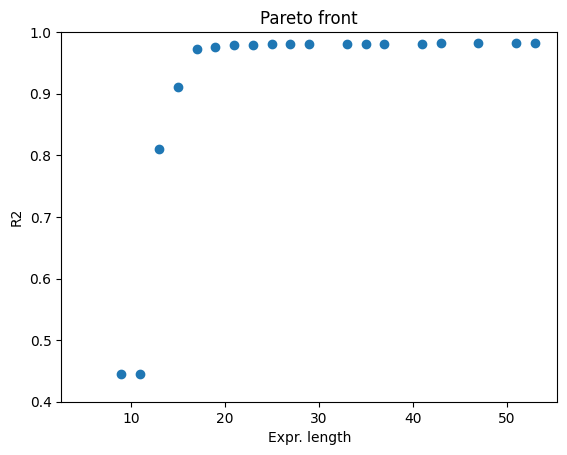

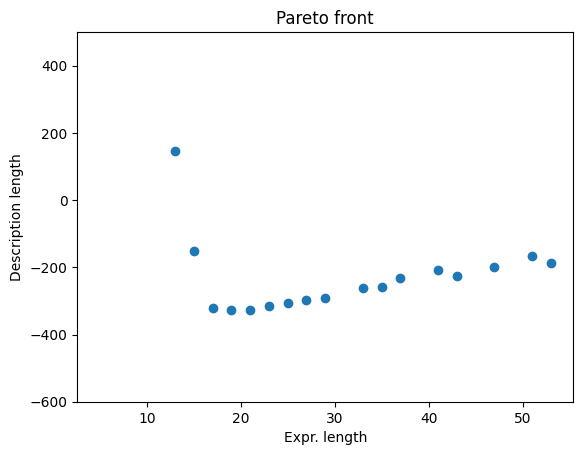

In [19]:
# Pareto front of objective values (R2,length)
values = np.array([t['objective_values'] for t in reg.pareto_front_])
plt.plot(values[:,1], -values[:,0], 'o')
plt.xlabel ('Expr. length')
plt.ylabel ('R2')
plt.title ('Pareto front')
plt.ylim((0.4, 1))
plt.show()

# Description length
values = np.array([(*t['objective_values'], t['minimum_description_length']) for t in reg.pareto_front_])

plt.plot(values[:,1], values[:,2], 'o')
plt.xlabel ('Expr. length')
plt.ylabel ('Description length')
plt.title ('Pareto front')
plt.ylim((-600, 500))
plt.show()


(0.000 + (1.000 * (((4.654 + ((-7.311) * x1)) / ((5.723 * x1) + (2.813 / ((0.526 * x1) + (-0.631))))) - ((-1.702) + ((-0.298) * x1)))))


0.298*x1 + 1.0*(4.654 - 7.311*x1)/(5.723*x1 + 2.813/(0.526*x1 - 0.631)) + 1.702

(0.897068804*x1**3 + 0.201799722000001*x1**2 + 1.753234474*x1 + 1.851052)/(3.010298*x1**2 - 3.611213*x1 + 2.813)

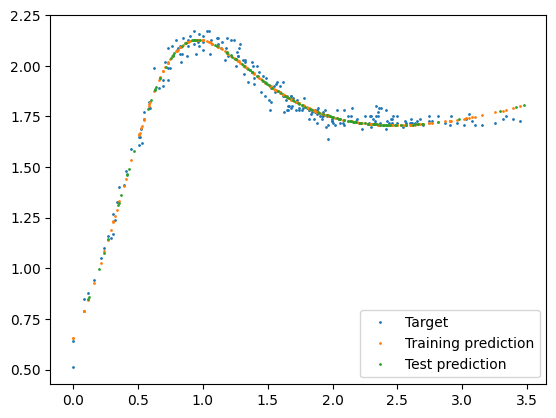

In [8]:
# simplification / symbolic manipulation

m = reg.model_
s = reg.get_model_string(m, 3).lower()
print(s)
expr = parse_expr(s)
simplexpr = simplify(expr)

display(expr)
display(simplexpr)

x1 = Symbol('x1')
f = lambdify(x1, simplexpr, "numpy") # create a python function and use numpy backend

plt.plot(X_train[:,0], y_train, 'o', label='Target', markersize=1)
plt.plot(X_train[:,0], f(X_train), 'o', label='Training prediction', markersize=1)
plt.plot(X_test[:,0], f(X_test), 'o', label='Test prediction', markersize=1)
plt.legend()
plt.show()

<lambdifygenerated-7>:2: RuntimeWarning: divide by zero encountered in divide
  return 0.2110122751898444*x1 + 0.832718551158905 + 2.1214823455271699/(4.2677178382873535*x1 + 0.49319715932441355*(7.1792197227478027 - 12.0164718627929688*x1)/x1)


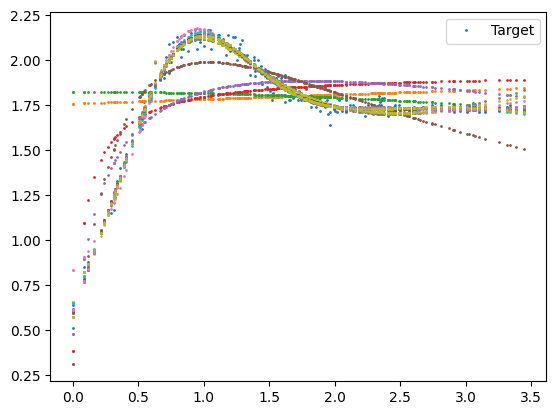

In [9]:
all_exprs = np.array([parse_expr(reg.get_model_string(t["tree"], 16).lower()) for t in reg.pareto_front_]) # get all expressions from Pareto front

all_funcs = [lambdify(x1, expr, "numpy") for expr in all_exprs] # convert expressions to Python functions

plt.plot(X_train[:,0], y_train, 'o', label='Target', markersize=1)
for f in all_funcs:
    plt.plot(X_train[:,0], f(X_train), 'o', markersize=1)
plt.legend()
plt.show()

In [20]:
# cross-validation

reg_v1 = SymbolicRegressor(
        allowed_symbols= "add,sub,mul,div,constant,variable",
        population_size= 1000,
        pool_size= 1000,
        generations= 50,
        female_selector= "tournament",
        male_selector= "tournament",
        tournament_size= 3,
        optimizer_iterations= 30,
        optimizer='lm',
        epsilon= 1e-05,
        max_evaluations= 1000000,
        max_length= 50,
        model_selection_criterion= "minimum_description_length",
        mutation_probability= 0.15,
        objectives= [ 'r2', 'length' ],
        random_state= None,
        uncertainty= [sErr],
        n_threads=0
        )



reg_v2 = SymbolicRegressor(
        allowed_symbols= "add,sub,mul,div,log,exp,aq,pow,sqrt,cbrt,tanh,constant,variable", # aq(a,b) = a / sqrt(b² + 1)
        population_size= 1000,
        pool_size= 1000,
        generations= 50,
        female_selector= "tournament",
        male_selector= "tournament",
        tournament_size= 3,
        optimizer_iterations= 30,
        optimizer='lm',
        epsilon= 1e-05,
        max_evaluations= 1000000,
        max_length= 50,
        model_selection_criterion= "minimum_description_length",
        mutation_probability= 0.15,
        objectives= [ 'r2', 'length' ],
        random_state= None,
        uncertainty= [sErr],
        n_threads=0
        )


scores_v1 = cross_val_score(reg_v1, X, y, cv=5)
scores_v2 = cross_val_score(reg_v2, X, y, cv=5)
print(f'v1 CV score (avg): {np.mean(scores_v1):0.3} (std error: {np.std(scores_v1)/math.sqrt(len(scores_v1)):0.5}')
print(f'v2 CV score (avg): {np.mean(scores_v2):0.3} (std error: {np.std(scores_v2)/math.sqrt(len(scores_v2)):0.5}')


v1 CV score (avg): 0.91 (std error: 0.041355
v2 CV score (avg): 0.932 (std error: 0.023732
